# Multimarginal OT

We consider in this tutorial the resolution of the multimarginal OT problem, as first formulated in {cite}`gangbo:98` and solved numerically in {cite}`benamou:15` using entropic regularization.

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.patches as ptc
import matplotlib.pyplot as plt

from ott.experimental import mmsinkhorn

We sample 4 small and uniform point clouds, each of size 6, in dimension 2, and solve the regularized multimarginal OT problem using the {class}`~ott.experimental.mmsinkhorn.MMSinkhorn` solver. By default, the squared-Euclidean distance is used to compare the pairs of points.

In [2]:
n_s, d = [6] * 4, 2

rngs = jax.random.split(jax.random.PRNGKey(0), len(n_s))
x_s = [jax.random.uniform(rng, (n, d)) for rng, n in zip(rngs, n_s)]
a_s = None

out = mmsinkhorn.MMSinkhorn()(x_s=x_s, a_s=a_s, epsilon=1e-2)

We now extract the biggest mass transfers across 4-tuples of points (one from each point cloud) using the {class}`multimarginal OT output object <ott.experimental.mmsinkhorn.MMSinkhornOutput>`.

In [3]:
top_k = n_s[0] * 2
val, idx = jax.lax.top_k(out.tensor.ravel(), top_k)
indices = jnp.unravel_index(idx, n_s)

A small function to help plot 4-tuples.

In [4]:
def ccworder(A: jnp.ndarray) -> jnp.ndarray:
    # https://stackoverflow.com/questions/5040412/how-to-draw-the-largest-polygon-from-a-set-of-points
    A = A - jnp.mean(A, 0)[None]
    return jnp.argsort(jnp.arctan2(A[:, 1], A[:, 0]))

We can now plot some elements of the multimarginal OT tensor, by representing 4-tuples as polygons.

Because the marginal distributions are uniform, and the number of points in each point cloud is the same (here 6), we expect that the OT tensor will be close, numerically, to a polymatching tensor of size $6^4$. 

We list the 4-tuples with the largest 12 transport values, each displayed as a quadrilateral linking those 4 points, filled with a transparency that is proportional to the transported mass. We do observe that only 6 of these 4-tuples stand out, the remaining 6 being barely visible due to their low transparency.

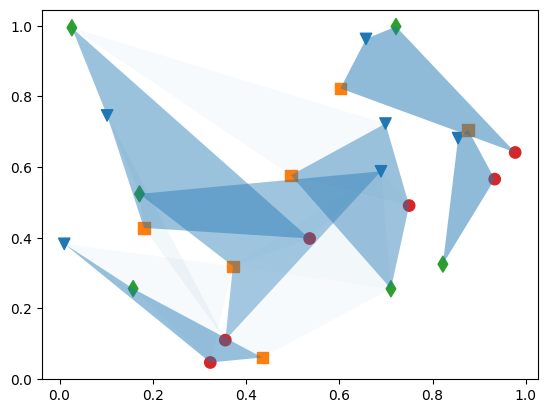

In [5]:
# Setttings for plot
markers = "vsdo"

fig, ax = plt.subplots()
for i in range(len(n_s)):
    ax.scatter(
        out.x_s[i][:, 0],
        out.x_s[i][:, 1],
        s=400 * out.a_s[i],
        marker=markers[i],
    )

for j in range(top_k):
    points = [out.x_s[i][indices[i][j], :] for i in range(len(n_s))]
    # reorder to ensure polygons have maximal area
    points = [points[i] for i in ccworder(jnp.array(points))]
    points = ptc.Polygon(points, fill=True, alpha=0.5 * float(val[j] * n_s[0]))
    ax.add_patch(points)